In [1]:
import pandas
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset, random_split,DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor,v2
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import PIL
import wandb
wandb.login()
wandb.init(
    # set the wandb project where this run will be logged
    project="Handwriting Recognition",

    # track hyperparameters and run metadata
    config={
        "learning_rate": 1e-4,
        "architecture": "ResNet",
        "dataset": "https://github.com/wblachowski/bhmsds?tab=readme-ov-file",
        "epochs": 10,
        "batch_size": 512,
        "Loss function": "Adam"
    }
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nilaygaitonde. Use `wandb login --relogin` to force relogin


In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available else "cpu")

In [3]:
symbols_compose = v2.Compose([
    v2.RandomAdjustSharpness(2),
    v2.RandomHorizontalFlip(p=0.3),
    v2.RandomRotation(degrees=15),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((28, 28)),
    PIL.ImageOps.invert,
    v2.ToTensor(),
])
mnist_compose = v2.Compose([
    v2.RandomAdjustSharpness(2),
    v2.RandomHorizontalFlip(p=0.3),
    v2.RandomRotation(degrees=15),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((28, 28)),
    v2.ToTensor()
])

/Users/nilaygaitonde/anaconda3/envs/deeplearning/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [66]:
batch_size = 512
symbols_dataset = datasets.ImageFolder(
    "/Users/nilaygaitonde/Documents/Projects/Maths/datasets/archive/extracted_images",
    transform=symbols_compose
)
mnist_train_dataset = torchvision.datasets.MNIST('./datasets/', train=True, download=True,transform=mnist_compose)
mnist_test_dataset = torchvision.datasets.MNIST('./datasets/', train=False, download=True,transform=mnist_compose)

In [4]:
numsym_compose = v2.Compose([
    v2.RandomAdjustSharpness(2),
    v2.RandomHorizontalFlip(p=0.3),
    v2.RandomRotation(degrees=15),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((28, 28)),
    v2.ToTensor(),
])
class NumSymDataset(Dataset):
    def __init__(self,root_dir,transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = os.listdir(root_dir)
        self.classes = []
        self.mapping = dict()
        self.get_classes()
    def __len__(self):
        return len(self.files)
    def __getitem__(self,idx):
        img_name = os.path.join(self.root_dir,self.files[idx])
        image = cv2.imread(img_name,cv2.COLOR_BGR2GRAY)
        image = cv2.bitwise_not(image)
        if self.transform:
            image = self.transform(image)
        return image, self.classes.index(str(self.files[idx]).split('-')[0])
    
    def get_classes(self):
        classes = list()
        for file in self.files:
            label = str(file).split('-')[0]
            if label not in classes:
                classes.append(label)
        for label in classes:
            self.classes.append(label)
    
            
test = NumSymDataset("/Users/nilaygaitonde/Documents/Projects/Maths/datasets/symbols",transform=numsym_compose)
test_loader = DataLoader(test,batch_size=512,shuffle=True)

dot


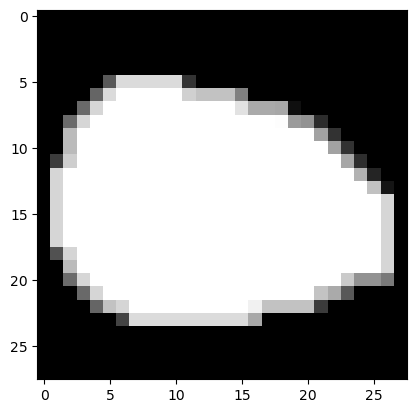

In [83]:
index = 123
plt.imshow(test[index][0][0],cmap="gray")
print(test.classes[test[index][1]])

In [26]:
class EarlyStopping():
    def __init__(self,threshold=0.01,patience=3):
        self.threshold = threshold
        self.patience = patience
        self.counter = 0
        self.prev_loss = None
        self.best_loss = None
    
    def __call__(self,loss):
        if self.best_loss == None:
            self.best_loss = loss
        elif self.best_loss - loss > self.threshold:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
        if self.counter == self.patience:
            return True
        return False
earlystopper = EarlyStopping(threshold=0.1,patience=5)

In [5]:
class HandwritingRecogniser(nn.Module):
    """
    Input Shape: (28,28)
    Output classes: 9
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=1,padding="same"), #(32,28,28)
            nn.BatchNorm2d(32), #(32,28,28)
            nn.ReLU() 
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding="same"), #(64,28,28)
            nn.BatchNorm2d(64), #(64,28,28)
            nn.ReLU()
        )
        self.res1 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(3,3),stride=1,padding="same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(3,3),stride=1,padding="same"),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding="same"), #(128,28,28)
            nn.BatchNorm2d(128), #(128,28,28)
            nn.MaxPool2d(2), # (128,14,14)
            nn.ReLU()
        )
        self.classification = nn.Sequential(
            nn.Flatten(), #(1,25088)
            nn.Linear(in_features=25088,out_features=1024,bias=True),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=1024,out_features=256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=256,out_features=len(test.classes)),
            nn.Softmax(dim=1)
        )
    def forward(self,X):
        out = self.conv1(X)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        logits = self.classification(out)
        return logits

In [6]:
def accuracy(true_y, pred_y):
    return (true_y == pred_y).float().mean()
def train_epoch(model, device, loss_fn,optimizer, X,y):
    logits = model(X)
    loss = loss_fn(logits, y)
    y_pred = torch.argmax(logits,dim=1)
    acc = accuracy(y,y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    wandb.log({"Loss": loss.item(),"Accuracy": acc.item()})
    return loss, logits,acc
    
def training_loop(dataset,n_epochs, model, device, loss_fn, optimizer,batch_interval=10,epoch_interval=1):
    for epoch in range(n_epochs):
        for i, (X,y) in enumerate(dataset):
            X = X.to(device)
            y = y.to(device)
            loss,logits,acc = train_epoch(model,device,loss_fn,optimizer,X,y)
            # break
            if i % batch_interval == 0:
                print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss} , Accuracy: {acc}")
        if epoch % epoch_interval == 0:
            print(f"Epoch: {epoch}, Loss: {loss}")

5


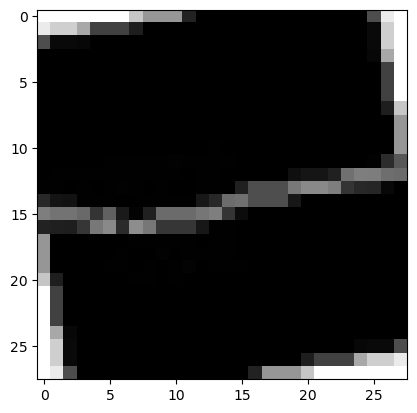

In [68]:
index = 2
plt.imshow(train_set[index][0][0],cmap="gray")
print(train_set[index][1])

In [7]:
n_epochs = 10
lr = 1e-4
base_model = HandwritingRecogniser().to(device)
# base_model.load_state_dict(torch.load("app/ai/models/model4.pth"))
# model = ExtendedHandwrittingRecognition(base_model,len(combinedDataset.classes)).to(device)
loss_fn = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(),lr=lr)
# training_loop(train_data,n_epochs,model,device,loss_fn,optimizer)
optimizer = torch.optim.Adam(base_model.parameters(),lr=lr)
training_loop(test_loader,n_epochs,base_model,device,loss_fn,optimizer)

Epoch: 0, Batch: 0, Loss: 2.890537738800049 , Accuracy: 0.0625
Epoch: 0, Batch: 10, Loss: 2.5465848445892334 , Accuracy: 0.484375
Epoch: 0, Batch: 20, Loss: 2.400096893310547 , Accuracy: 0.61328125
Epoch: 0, Batch: 30, Loss: 2.3137097358703613 , Accuracy: 0.701171875
Epoch: 0, Batch: 40, Loss: 2.241288423538208 , Accuracy: 0.775390625
Epoch: 0, Batch: 50, Loss: 2.197601318359375 , Accuracy: 0.806640625
Epoch: 0, Loss: 2.1738686561584473
Epoch: 1, Batch: 0, Loss: 2.2212166786193848 , Accuracy: 0.783203125
Epoch: 1, Batch: 10, Loss: 2.164067268371582 , Accuracy: 0.833984375
Epoch: 1, Batch: 20, Loss: 2.1362524032592773 , Accuracy: 0.869140625
Epoch: 1, Batch: 30, Loss: 2.1122679710388184 , Accuracy: 0.892578125
Epoch: 1, Batch: 40, Loss: 2.1054506301879883 , Accuracy: 0.892578125
Epoch: 1, Batch: 50, Loss: 2.092442512512207 , Accuracy: 0.908203125
Epoch: 1, Loss: 2.062912702560425
Epoch: 2, Batch: 0, Loss: 2.0667874813079834 , Accuracy: 0.93359375
Epoch: 2, Batch: 10, Loss: 2.06952023506

z y


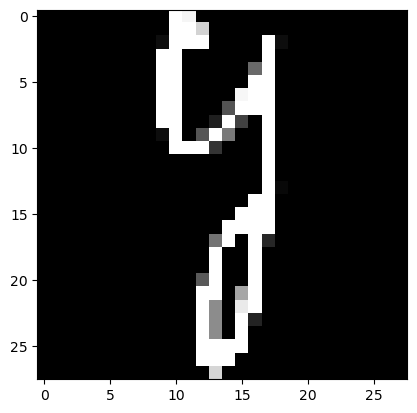

In [102]:
index = 1232
plt.imshow(test[index][0][0],cmap="gray")
print(test.classes[base_model(test[index][0].unsqueeze(0).to(device)).argmax().item()],test.classes[test[index][1]])

In [9]:
def test_model(model,device):
    model.eval()
    with torch.no_grad():
        for i, (X,y) in enumerate(val_data):
            X = X.to(device)
            y = y.to(device)
            logits = model(X)
            y_pred = torch.argmax(logits,dim=1)
            acc = accuracy(y,y_pred)
            print(f"Batch: {i}, Accuracy: {acc}")
test_model(base_model,device)

NameError: name 'val_data' is not defined

In [89]:
len(test.classes)

18

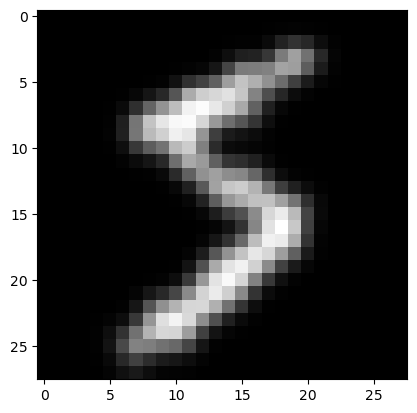

In [50]:
plt.imshow(train_dataset[0][0][0].numpy(),cmap="gray")

In [13]:
plt.imsave("app/ai/imgs/sample.png",train_dataset[0][0][0].numpy(),cmap='gray')

5


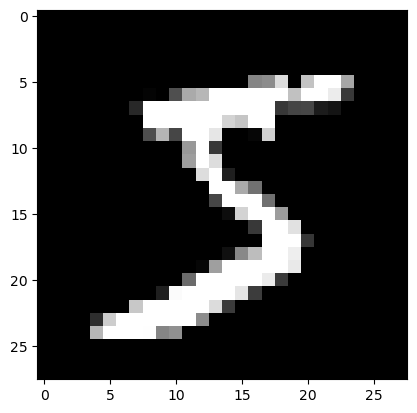

In [11]:
plt.imshow(train_dataset[0][0][0],cmap='gray')
print(train_dataset[0][1])

(4, 4)

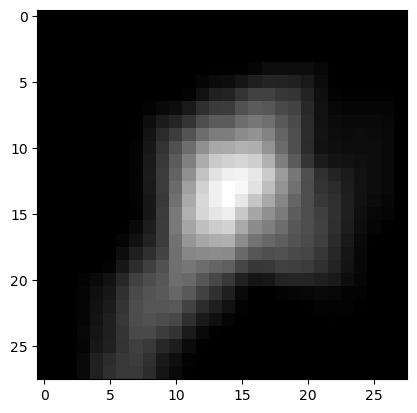

In [33]:
model = HandwritingRecogniser().to(device)
model.load_state_dict(torch.load("app/ai/models/model4.pth"))
model.eval()
idx = 53
plt.imshow(train_dataset[idx][0][0],cmap='gray')
model(train_dataset[idx][0].unsqueeze(0).to(device)).argmax().item(),train_dataset[idx][1]

'sub'

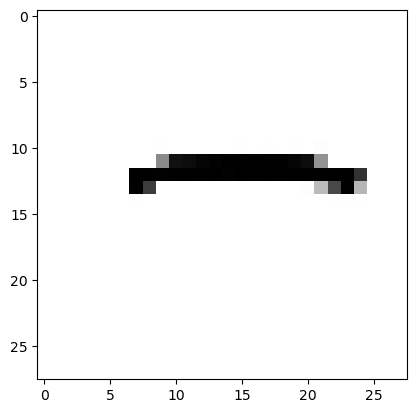

In [36]:
index = 32
plt.imshow(train_dataset[index][0][0],cmap='gray')
reverse_classes[model(train_dataset[index][0].unsqueeze(0).to(device)).argmax().item()]

In [41]:
reverse_classes[7]

'8'

In [40]:
print(train_dataset[index][0][0].numpy())

[[ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.  

In [26]:
data = train_dataset[0][0].unsqueeze(0).to(device)
model(data).argmax().item()

/Users/nilaygaitonde/anaconda3/envs/deeplearning/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


5

16 0 16 45


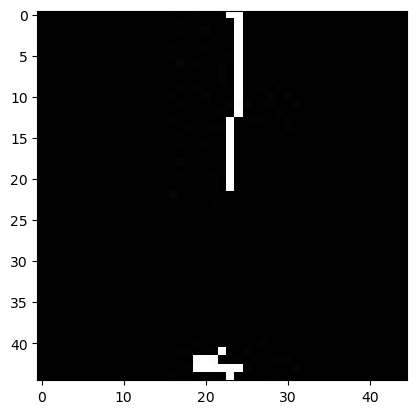

In [72]:
img = cv2.imread("datasets/archive/extracted_images/!/!_7731.jpg",cv2.IMREAD_GRAYSCALE)
img = 255 - img
plt.imshow(img,cmap='gray')
# invert the image it has white background and black text
plt.imshow(img,cmap='gray')
coords = cv2.findNonZero(img)
x,y,w,h = cv2.boundingRect(coords)
cropped = img[y:y+h,x:x+w]
# plt.imshow(cropped,cmap='gray')
print(x,y,w,h)

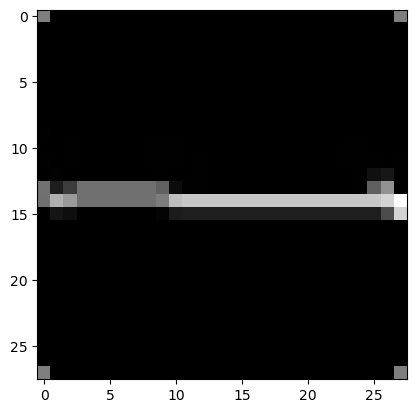

In [65]:
plt.imshow(bleh,cmap='gray')